In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import electricPotentialEnergy as pe

### Initialize the system

Initial Energy: 163.00355978668537


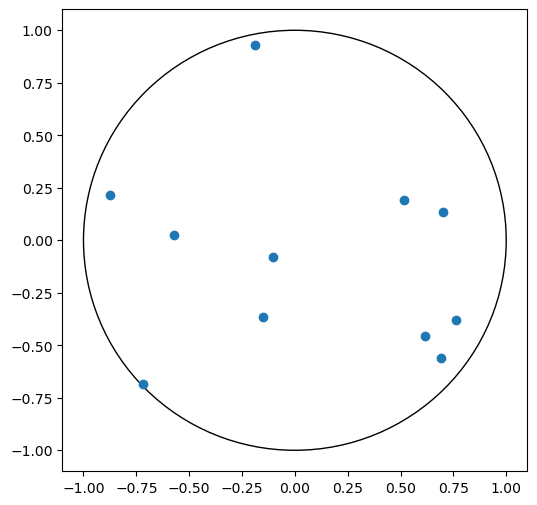

In [5]:
system = pe.Coulomb(11)

fig, ax = pe.plotState(system.state)
print(f"Initial Energy: {system.stateEnergy()}")

### Run Simulated Annealing

5102
Final Energy: 99.54106767920096


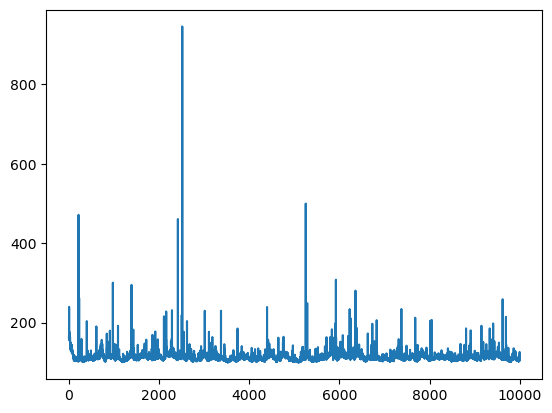

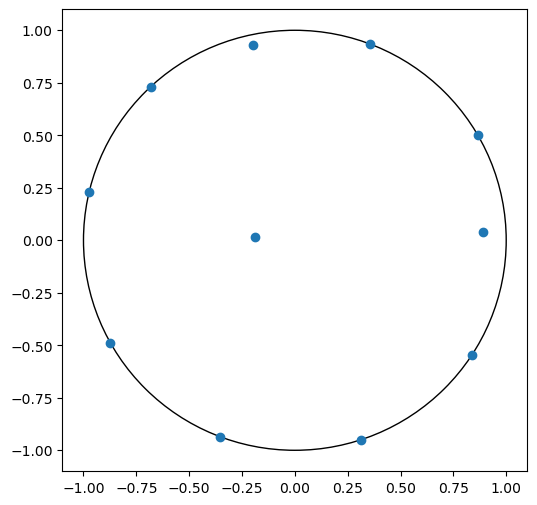

In [6]:
max_iters = 10000
initial_temp = 100
cooling_rate = 0.7
max_step = 0.5

filename = "test"

optimized_system, energy = pe.simulatedAnnealing(system, max_iters, initial_temp, cooling_rate, max_step, save_path=filename)

plt.plot(energy)
print(np.argmin(energy))

fig, ax = pe.plotState(optimized_system.state)
print(f"Final Energy: {optimized_system.stateEnergy()}")
plt.show()

### Load simulation results

In [7]:
saved_states = np.load(f"{filename}.npy")

### Create animation using simulation results

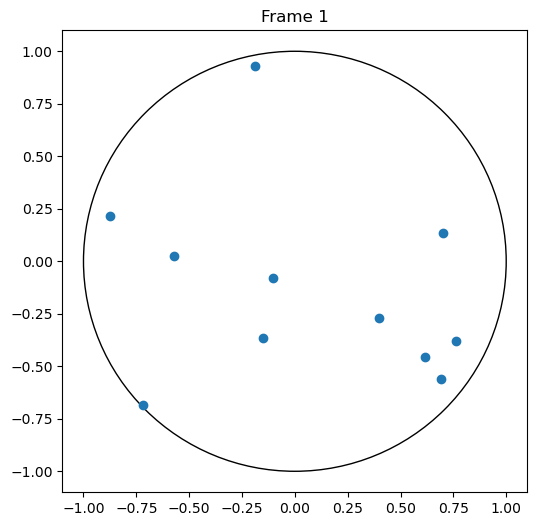

In [8]:
def update(frame):
    """Update function for the animation."""
    pe.plotState(saved_states[frame], animation=True, ax=ax)
    ax.set_title(f"Frame {frame+1}")

fig, ax = plt.subplots(figsize=(6, 6))
ani = animation.FuncAnimation(fig, update, frames=len(saved_states), interval=200)

ani.save(f"{filename}.mp4", fps=50)